### Import packages and data

In [4]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

### Preprocessing

In [6]:
df = pd.read_csv(csv_path)

In [7]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [23]:
TRAIN_SPLIT = 300000

In [24]:
tf.random.set_seed(13)

### Forecast univariate series

#### Select one column

In [25]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']

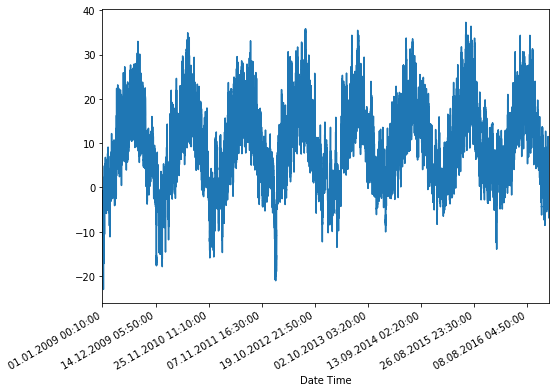

In [20]:
uni_data.plot(subplots=True);

#### Normalize

In [21]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [22]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [28]:
uni_data = uni_data.values

#### Create data

In [29]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [32]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [33]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

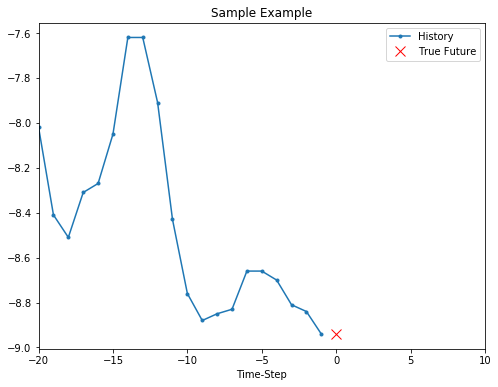

In [40]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

#### tf.data to shuffle, batch, and cache the dataset.

In [35]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [36]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#### Model

In [37]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [38]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [39]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


##### Train

In [43]:
EVALUATION_INTERVAL = 500
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/10
500/500 [==============================] - 4s 8ms/step - loss: 1.1271 - val_loss: 0.4045
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 0.9445 - val_loss: 0.2234
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 0.6107 - val_loss: 0.1607
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4148 - val_loss: 0.1271
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3603 - val_loss: 0.1112
Epoch 6/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2510 - val_loss: 0.1088
Epoch 7/10
500/500 [==============================] - 4s 8ms/step - loss: 0.2674 - val_loss: 0.1038
Epoch 8/10
500/500 [==============================] - 4s 8ms/step - loss: 0.1966 - val_loss: 0.1047
Epoch 9/10
500/500 [==============================] - 4s 8ms/step - loss: 0.1955 - val_loss: 0.1049
Epoch 10/10
500/500 [==============================] - 4s

##### Predict

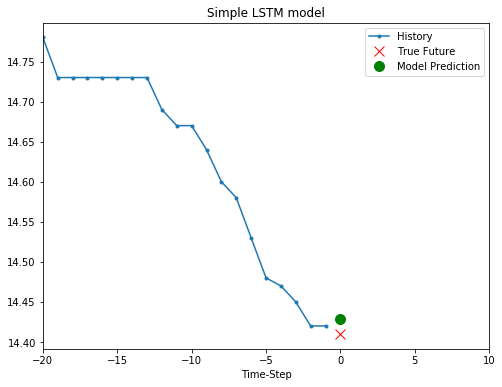

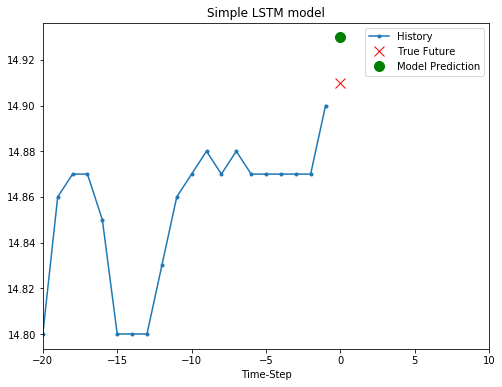

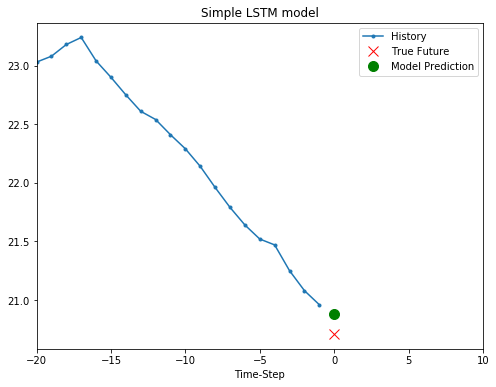

In [45]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()